# Landgebruik intrekgebied

### Dit python notebook laat een methode zien om op basis van een stroombaanberekening in iMOD het landgebruik van het intrekgebied te bepalen per pompputten bij een bepaalde maximale reistijd vanaf maaiveld. 

Nodig zijn;
    - een iff-bestand afkomstig uit een stroombaanberekening,
    - een idf-bestand met het lgn landgebruik.
    - een ipf-bestand met pompputten bevat. Het ipf bestand moet in ieder geval bevatten;
        * x en y coordinaten van het filter
        * modellaag waar het filter in zit
        * label voor de pompput (meerdere pompputten kunnen hetzelfde label bevatten, de reistijden worden dan geaggregeerd.)

### Stap 1
importeren modules ipf, idf en iff uit pyimod. En vervolgens in lezen van het ipf-, idf- en iff-bestand

In [1]:
from pyimod import ipf, iff, idf

putten      = r'C:\LOZA\Nijbeets_MIPWA\Stroombanen\tools\wel.ipf'
stroombanen = r'C:\LOZA\Nijbeets_MIPWA\Stroombanen\data\6_B1_BOEZEM\imodpath_plas.iff'
landgebruik = r'C:\LOZA\Nijbeets_MIPWA\iMOD\model\MIPWA_2.2\landgebruik\LGN6_MOZ.IDF'

putten_ipf      = ipf.ipf(putten, ['f', 'f', 'f', 's', 's', 'f', 'f', 'i'])
stroombanen_iff = iff.iff(stroombanen)
landgebruik_idf = idf.idf(landgebruik)

### Stap 2
Vervolgens wordt per eindpunt uit het iff-bestand gekeken of dit overeenkomt met een pompput uit het ipf-bestand. Voorwaarde voor overeenkomt is dat de horizontale afstand kleiner is dan 'dmin', de modellaag van het eindpunt overeenkomt met die van de pompput en de reistijd korter is dan 'tmin'. Wanneer er een overeenkomst is wordt de het landgebruik uit het idf-bestand toegevoegd aan een dictonary, waarbij de key gelijk is aan het label van de betreffende pompput.

De variabele 'xcol', 'ycol', 'lcol' en 'labcol' geven het kolomnummer in het ipf-bestand van respectievelijk x-coordinaat, y-coordinaat, modellaag en label. 

In [2]:
dmin = 25.0
tmin = 1000.0
xcol, ycol, lcol, labcol = 0, 1, 7, 3
lgn_put = {}
for i, end in stroombanen_iff.endpoints.iteritems():
    for pnt in putten_ipf.features:
        d = ((pnt[xcol]-end[0])**2+(pnt[ycol]-end[1])**2)**0.5
        if d<dmin and pnt[lcol]==end[4] and end[3]<tmin:
            label = pnt[labcol]
            begin = stroombanen_iff.beginpoints[i]
            lgn_end = int(landgebruik_idf.get_value(begin[0], begin[1]))
            if lgn_put.has_key(label):
                lgn_put[label].append(lgn_end)                
            else:
                lgn_put[label] = [lgn_end]

### Stap 3
Omzetten van de LGN-code naar landgebruik

In [3]:
lgn = {1:  "Gras",\
       2:  "Mais",\
       3:  "Aardappelen",\
       4:  "Bieten",\
       5:  "Granen",\
       6:  "Overige landbouw",\
       8:  "Glastuinbouw",\
       9:  "Boomgaard",\
       10: "Bollen",\
       11: "Loofbos",\
       12: "Naaldbos",\
       13: "Natte natuur",\
       14: "Droge natuur",\
       15: "Kale grond",\
       16: "Zoet water",\
       17: "Zout water",\
       18: "Stedelijk gebied",\
       19: "Donker naaldbos"}

landgebruik_put = {}
for l, lgn_p in lgn_put.iteritems():
    landgebruik_l = []
    for i in lgn_p:
        landgebruik_l.append(lgn[i])
    landgebruik_put[l] = landgebruik_l 


### Stap 4
In de volgende stap word het relatieve landgebruik per type geplot.

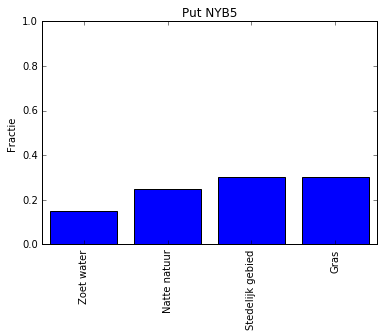

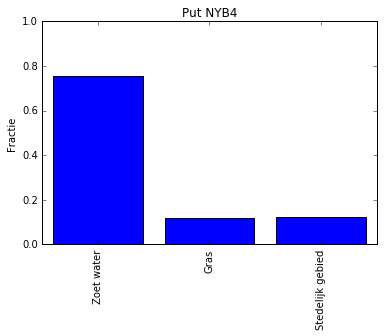

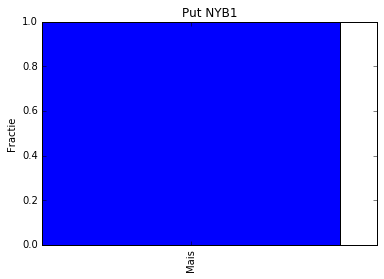

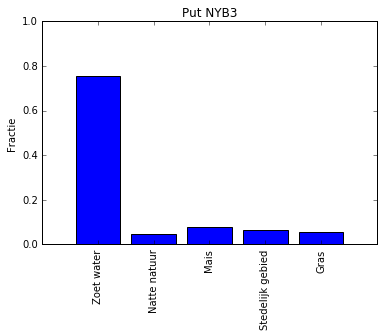

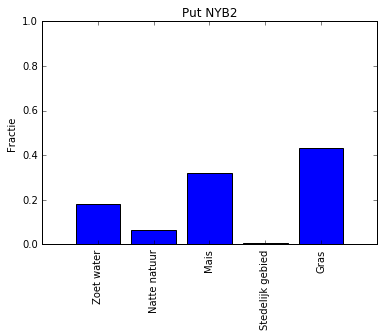

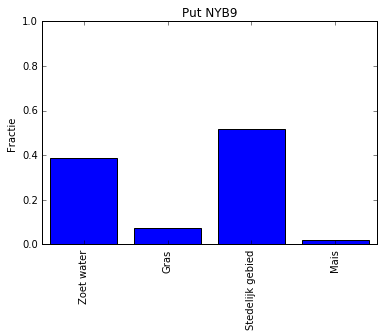

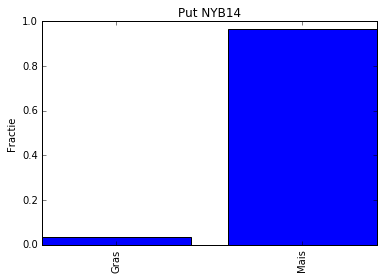

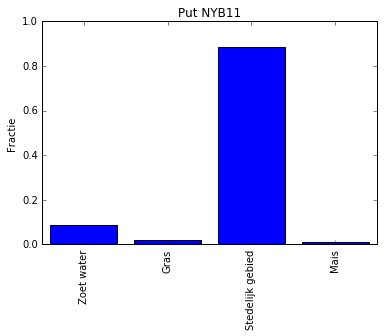

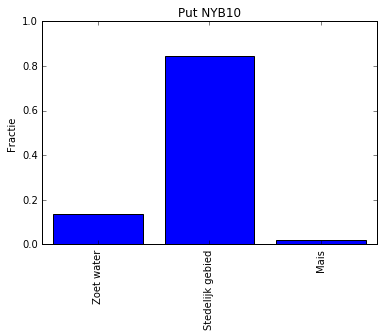

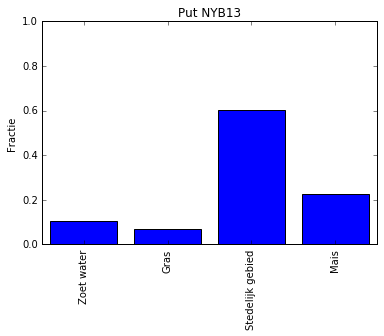

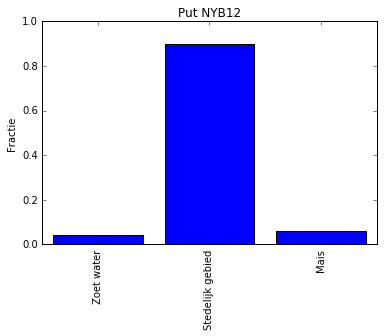

In [4]:
import matplotlib.pyplot as plt
import collections
import numpy

for lab, l in landgebruik_put.iteritems():
    bar = dict(collections.Counter(l))
    val = numpy.array(bar.values(), numpy.float)
    val = val/sum(val)
    plt.bar(range(len(bar)), val, tick_label=bar.keys(), align="center")
    plt.xticks(rotation='vertical')
    plt.ylim([0, 1])
    plt.title("Put " + lab)
    plt.ylabel('Fractie')
    plt.show()